In [1]:
# Importando as ferramentas necessárias
import pandas as pd
# Traduz Python para SQL
from sqlalchemy import create_engine
# Segurança
import os
from dotenv import load_dotenv
# Carrega a senha 
load_dotenv()
# Guarda a senha em uma variável
conexao_render = os.environ.get('DATABASE_URL')
# Criando a conexão com o banco de dados
engine = create_engine(conexao_render)
# Testando o SQL
query = "SELECT * FROM clientes LIMIT 5"
print("Buscando os dados no Render")
# Leva a query e traz a resposta, colocando-a em um DataFrame
df_amostra = pd.read_sql(query, engine)
df_amostra



Buscando os dados no Render


,id_cliente,renda_mensal,score_interno,estado_civil
0,1,5245.071230,727,Solteiro
1,2,4292.603548,604,Casado
2,3,5471.532807,616,Solteiro
3,4,6784.544785,934,Divorciado
4,5,4148.769938,308,Divorciado


In [3]:
# Verificando as linhas e colunas da tabela faturas
query_faturas = "SELECT * FROM faturas LIMIT 5"
df_amostra_faturas = pd.read_sql(query_faturas, engine)
df_amostra_faturas

,id_cliente,mes_referencia,valor_fatura,pago_em_dia
0,1,1,4954.620957,1
1,1,2,4974.313479,1
2,1,3,211.124230,1
3,1,4,1840.555543,0
4,1,5,531.341796,1


In [4]:
# Criandouma query para responder o seguinte questionamento: Quais são os clientes com o maior número de faturas atrasadas e qual o Score deles?
query_faturas_atrasadas = """
SELECT
    c.id_cliente,
    c.score_interno,
    c.renda_mensal,
    COUNT(f.id_cliente) as total_faturas,
    SUM(CASE WHEN f.pago_em_dia = 0 THEN 1 ELSE 0 END) as quantidade_faturas_atrasadas
FROM clientes as c
join faturas as f
    on c.id_cliente = f.id_cliente
GROUP BY
    c.id_cliente, c.score_interno, c.renda_mensal
ORDER BY
    quantidade_faturas_atrasadas DESC
LIMIT 10;
""" 
print("Analisando a quantidade de faturas atrasadas por clientes e cruzando os dados no Render")
df_faturas_atrasadas = pd.read_sql(query_faturas_atrasadas, engine)
df_faturas_atrasadas

Analisando a quantidade de faturas atrasadas por clientes e cruzando os dados no Render


,id_cliente,score_interno,renda_mensal,total_faturas,quantidade_faturas_atrasadas
0,268,384,2354.787933,6,5
1,75,416,1621.000000,6,4
2,6,372,4148.794565,6,4
3,892,375,5260.911047,6,4
4,584,379,7906.039287,6,4
5,238,401,4779.681472,6,4
6,315,389,6458.218211,6,4
7,793,387,4907.368256,6,4
8,843,313,2815.916968,6,4
9,533,409,4400.880302,6,4


## O valor da fatura influencia se ela é paga ou não?

In [ ]:
# Analisando se o valor das faturas influencia no atraso do pagamento
query_valor_faturas = """
SELECT
    CASE WHEN pago_em_dia = 0 THEN 'Atrasada' ELSE 'Paga em dia' END as status_fatura,
    AVG(valor_fatura) as valor_medio_fatura,
    COUNT(*) as quantidade_faturas
FROM faturas
GROUP BY 
    pago_em_dia;
"""
print("Analisando o valor médio das faturas")
df_valor_medio = pd.read_sql(query_valor_faturas, engine)
df_valor_medio

Analisando o valor médio das faturas


,status_fatura,valor_medio_fatura,quantidade_faturas
0,Atrasada,2566.621141,707
1,Paga em dia,2607.435224,5293


## Calculando quais os meses que possuem a maior quantidade de faturas atrasadas em ordem decrescente

In [8]:
# Query
query_mes = """
SELECT
    mes_referencia,
    COUNT(*) as quantidade_faturas_atrasadas
FROM faturas
WHERE pago_em_dia = 0
GROUP BY 
    mes_referencia
ORDER BY 
    quantidade_faturas_atrasadas DESC;
"""
print("Analisando quais são os meses com mais faturas atrasadas")
df_meses = pd.read_sql(query_mes, engine)
df_meses

Analisando quais são os meses com mais faturas atrasadas


,mes_referencia,quantidade_faturas_atrasadas
0,6,128
1,4,121
2,3,118
3,2,117
4,5,112
5,1,111


## Avaliando qual estado civil possui a maior quantidade de faturas atrasadas

In [5]:
# Query para calcular a quantidade de faturas atrasadas por estado civil
query_estado_civil = """
SELECT
    estado_civil,
    COUNT(*) as quantidade_faturas_atrasadas
FROM clientes as c
join faturas as f
    on c.id_cliente = f.id_cliente
WHERE f.pago_em_dia = 0
GROUP BY
    estado_civil
ORDER BY
    quantidade_faturas_atrasadas DESC;
"""
print("Analisando a quantidade de faturas atrasadas por estado civil")
df_estado_civil = pd.read_sql(query_estado_civil, engine)
df_estado_civil

Analisando a quantidade de faturas atrasadas por estado civil


,estado_civil,quantidade_faturas_atrasadas
0,Viúvo,197
1,Solteiro,185
2,Divorciado,176
3,Casado,149


## O cliente deixa de pagar mais quando a fatura custa mais que a metade do salário dele?

In [7]:
## Query para analisar a relação entre o salário, valor da fatura e o atraso no pagamento
query_salario_fatura = """
with calculando_relacao as (
SELECT
    (f.valor_fatura / c.renda_mensal) as relacao_fatura_salario
FROM clientes as c
join faturas as f
    on c.id_cliente = f.id_cliente
WHERE f.pago_em_dia = 0
)
SELECT
    CASE
        WHEN relacao_fatura_salario > 0.5 THEN 'Alta relação'
        WHEN relacao_fatura_salario BETWEEN 0.2 AND 0.5 THEN 'Média relação'
        ELSE 'Baixa relação'
        END as categoria_relacao
    , COUNT(*) as quantidade_faturas_atrasadas
FROM calculando_relacao
GROUP BY
    categoria_relacao
ORDER BY
    quantidade_faturas_atrasadas DESC;
"""
print("Analisando a quantidade de faturas atrasadas por categoria de relação entre fatura e salário")
df_relacao = pd.read_sql(query_salario_fatura, engine)
df_relacao

Analisando a quantidade de faturas atrasadas por categoria de relação entre fatura e salário


,categoria_relacao,quantidade_faturas_atrasadas
0,Alta relação,404
1,Média relação,192
2,Baixa relação,111


## Gráfico de Pizza : Comprometimento da renda

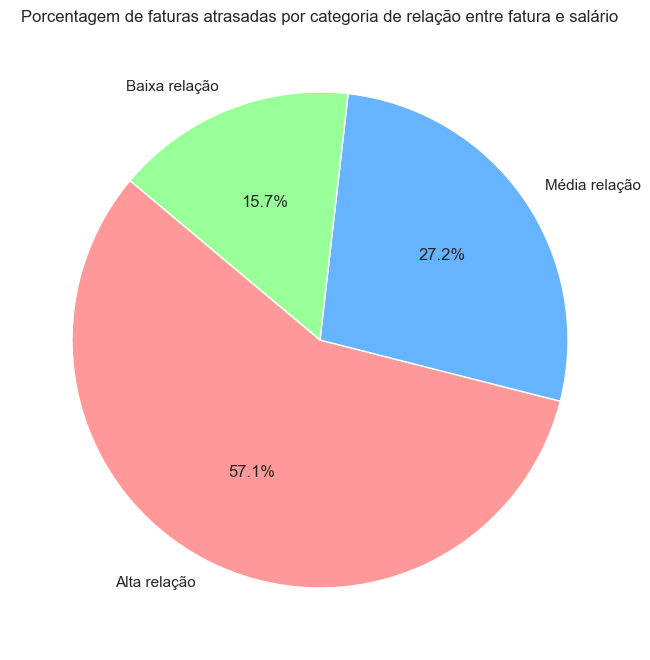

In [8]:
plt.figure(figsize=(8, 80))
# Preenchendo o gráfico com os dados do d_relacao
plt.pie(
    df_relacao['quantidade_faturas_atrasadas'],
    labels=df_relacao['categoria_relacao'],
    autopct='%1.1f%%',
    startangle=140,
    colors=['#ff9999','#66b3ff','#99ff99']
)
plt.title('Porcentagem de faturas atrasadas por categoria de relação entre fatura e salário')
plt.show()

## Prova real do Score (Classificação)

In [3]:
# Calculando a quantidade de faturas atrasadas por faixa de Score
query_score = """ 
SELECT
    CASE
        WHEN c.score_interno >= 800 THEN 'Score A - Excelente'
        WHEN c.score_interno BETWEEN 500 AND 799 THEN 'Score B - Médio'
        ELSE 'Score C - Baixo (risco)'
    END as categorias_scores,
    COUNT(*) as quantidade_faturas_atrasadas
FROM clientes as c
join faturas as f
    on c.id_cliente = f.id_cliente
WHERE f.pago_em_dia = 0
GROUP BY
    categorias_scores
ORDER BY
    quantidade_faturas_atrasadas DESC;
"""
print("Analisando a quantidade de faturas atrasadas por categoria de Score")
df_score = pd.read_sql(query_score, engine)
df_score

Analisando a quantidade de faturas atrasadas por categoria de Score


,categorias_scores,quantidade_faturas_atrasadas
0,Score C - Baixo (risco),465
1,Score B - Médio,138
2,Score A - Excelente,104


## Gerando gráficos

C:\Users\laise\AppData\Local\Temp\ipykernel_4816\163983991.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(


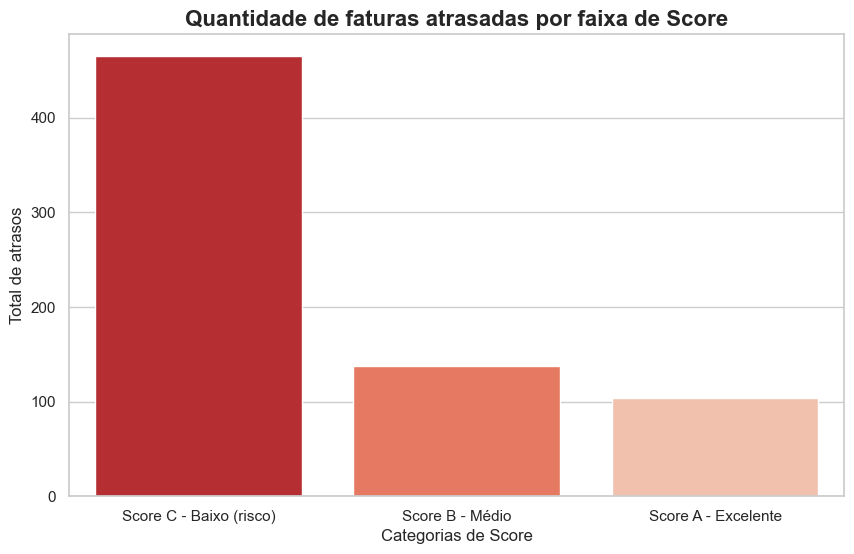

In [ ]:
## Gráfico de barras
# Importando as bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns
# Preparando a tela
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# Criando o gráfico de barrras para a quantidade de faturas atrasadas por categoria de Score
grafico = sns.barplot(
    x='categorias_scores',
    y='quantidade_faturas_atrasadas',
    data=df_score,
    palette='Reds_r'
)
# Colocando as legendas e o título do gráfico
plt.title('Quantidade de faturas atrasadas por faixa de Score', fontsize=16, fontweight='bold')
plt.xlabel('Categorias de Score', fontsize=12)
plt.ylabel('Total de atrasos', fontsize=12)
# Exibindo na tela
plt.show()
